In [ ]:
# Following tutorial at: https://github.com/fzenke/spytorch/blob/main/notebooks/SpyTorchTutorial2.ipynb

In [ ]:
# imports
import os

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns

import torch
import torch.nn as nn
import torchvision

In [ ]:
torch.__version__

'2.0.1+cu118'

In [ ]:
# The network structure dictated by the Fashion MNIST dataset
nb_inputs = 28*28
nb_hidden = 100
nb_outputs = 10

time_step = 1e-3
nb_steps = 100

batch_size = 256

In [ ]:
dtype = torch.float

# Check whether a GPU is availible
if torch.cuda.is_available():
  device = torch.device("cuda")
else:
  device = torch.device("cpu")

In [ ]:
# Loading in the dataset
root = os.path.expanduser("~/data/datasets/torch/fashion-mnist")
train_dataset = torchvision.datasets.FashionMNIST(root, train=True, transform=None, target_transform=None, download=True)
test_dataset = torchvision.datasets.FashionMNIST(root, train=False, transform=None, target_transform=None, download=True)

In [ ]:
# Standardize data
x_train = np.array(train_dataset.data, dtype=float)
x_train = x_train.reshape(x_train.shape[0],-1)/255
x_test = np.array(test_dataset.data, dtype=float)
x_test = x_test.reshape(x_test.shape[0],-1)/255

y_train = np.array(train_dataset.targets, dtype=int)
y_test  = np.array(test_dataset.targets, dtype=int)

(-0.5, 27.5, 27.5, -0.5)

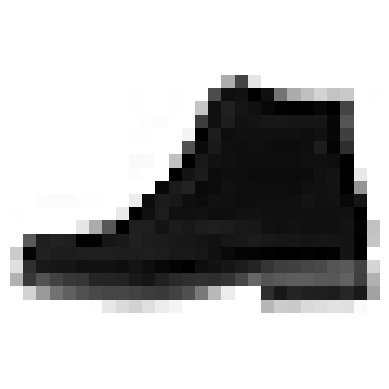

In [ ]:
# Plotting one of the raw datapoints as an example
data_id = 42
plt.imshow(x_train[data_id].reshape(28,28), cmap=plt.cm.gray_r)
plt.axis("off")

Ideally we want a temporal dynamic to make use of spike timing. So, we will make a 'spike latency code'.

In [ ]:
def current2firing_time(x, tau=20, thr=0.2, tmax=1.0, epsilon=1e-7):
  """
  Computes first firing time latency for a current input x assuming the charge
  time of a current based LIF neuron

  Args:
    x -- the "current" values

  Kwargs
    tau -- The membrane time constant of the LIF neuron to be charged
    thr -- The firing threshold value
    tmax -- The maximum time returned
    epsilon -- A generic small epsilon > 0

  Returns:
    T -- time to first spike for each "current" x
  """
  idx = x < thr
  x = np.clip(x, thr+epsilon, 1e9) # every value in x lower than 'thr+epsilon' goes to 'thr+epsilon' and above 1e9 go to 1e9
  T = tau * np.log(x / (x - thr))
  T[idx] = tmax
  return T

def sparse_data_generator(X, y, batch_size, nb_steps, nb_units, shuffle=True ):
    """ This generator takes datasets in analog format and generates spiking network input as sparse tensors.

    Args:
        X: The data ( sample x event x 2 ) the last dim holds (time,neuron) tuples
        y: The labels
    """

    labels_ = np.array(y,dtype=int)
    number_of_batches = len(X)//batch_size
    sample_index = np.arange(len(X))

    # compute discrete firing times
    tau_eff = 20e-3/time_step
    firing_times = np.array(current2firing_time(X, tau=tau_eff, tmax=nb_steps), dtype=int)
    print(firing_times)
    unit_numbers = np.arange(nb_units)

    if shuffle:
        np.random.shuffle(sample_index)

    total_batch_count = 0
    counter = 0
    while counter<number_of_batches:
        batch_index = sample_index[batch_size*counter:batch_size*(counter+1)]

        coo = [ [] for i in range(3) ]
        for bc,idx in enumerate(batch_index):
            c = firing_times[idx]<nb_steps
            times, units = firing_times[idx][c], unit_numbers[c]

            batch = [bc for _ in range(len(times))]
            coo[0].extend(batch)
            coo[1].extend(times)
            coo[2].extend(units)

        i = torch.LongTensor(coo).to(device)
        v = torch.FloatTensor(np.ones(len(coo[0]))).to(device)

        X_batch = torch.sparse.FloatTensor(i, v, torch.Size([batch_size,nb_steps,nb_units])).to(device)
        y_batch = torch.tensor(labels_[batch_index],device=device)

        yield X_batch.to(device=device), y_batch.to(device=device)

        counter += 1

In [ ]:
x_train.shape

(60000, 784)

[[100 100 100 ... 100 100 100]
 [100 100 100 ... 100 100 100]
 [100 100 100 ... 100 100 100]
 ...
 [100 100 100 ... 100 100 100]
 [100 100 100 ... 100 100 100]
 [100 100 100 ... 100 100 100]]


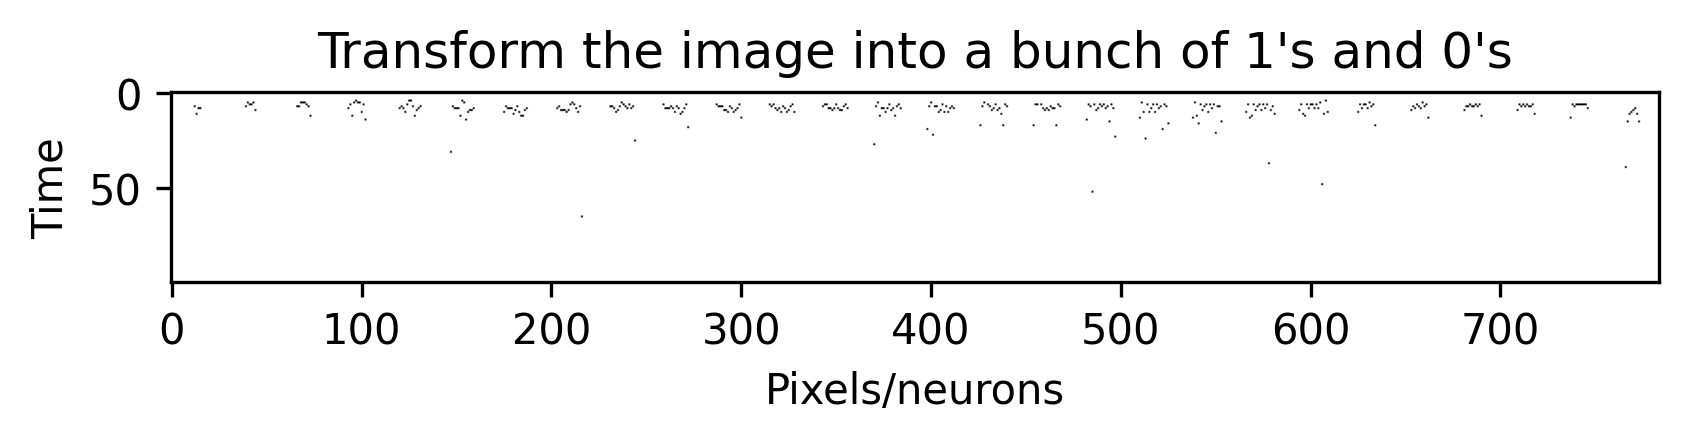

In [ ]:
# Plotting the input into the system
for x_loc, y_loc in sparse_data_generator(x_train, y_train, batch_size, nb_steps, nb_inputs):
  # print("\nx_loc:\n")
  # print(x_loc.to_dense())
  # print("\ny_loc:\n")
  # print(y_loc)
  # print("\n")
  plt.figure(dpi=300)
  plt.imshow(x_loc.to_dense().cpu()[0], cmap="gray_r")
  plt.xlabel("Pixels/neurons")
  plt.ylabel("Time")
  plt.title("Transform the image into a bunch of 1's and 0's")

  plt.show()

  break

Setup of the spiking network model
* This is the same as the last tutorial where the classification of the picture is the node with the highest voltage

In [ ]:
tau_mem = 10e-3
tau_syn = 5e-3

alpha = float(np.exp(-time_step / tau_syn))
beta = float(np.exp(-time_step / tau_mem))

In [ ]:
weight_scale = 7 * (1.0 - beta) # This should give us some spikes to begin with

w1 = torch.empty((nb_inputs, nb_hidden),  device=device, dtype=dtype, requires_grad=True)
torch.nn.init.normal_(w1, mean=0.0, std=weight_scale/np.sqrt(nb_inputs))

w2 = torch.empty((nb_hidden, nb_outputs), device=device, dtype=dtype, requires_grad=True)
torch.nn.init.normal_(w2, mean=0.0, std=weight_scale/np.sqrt(nb_hidden))

print("init_done")

init_done


In [ ]:
def plot_voltage_traces(mem, spk=None, dim=(3,5), spike_height=5):
    gs=GridSpec(*dim)
    if spk is not None:
        dat = 1.0*mem
        dat[spk>0.0] = spike_height
        dat = dat.detach().cpu().numpy()
    else:
        dat = mem.detach().cpu().numpy()
    for i in range(np.prod(dim)):
        if i==0: a0=ax=plt.subplot(gs[i])
        else: ax=plt.subplot(gs[i],sharey=a0)
        ax.plot(dat[i])
        ax.axis("off")

Training the network

In [ ]:
# THESE are are the same from the last tutorial
# We are calculating the loss with the max voltage of the nodes


class SurrGradSpike(torch.autograd.Function):
    """
    Here we implement our spiking nonlinearity which also implements
    the surrogate gradient. By subclassing torch.autograd.Function,
    we will be able to use all of PyTorch's autograd functionality.
    Here we use the normalized negative part of a fast sigmoid
    as this was done in Zenke & Ganguli (2018).
    """

    scale = 100.0 # controls steepness of surrogate gradient

    @staticmethod
    def forward(ctx, input):
        """
        In the forward pass we compute a step function of the input Tensor
        and return it. ctx is a context object that we use to stash information which
        we need to later backpropagate our error signals. To achieve this we use the
        ctx.save_for_backward method.
        """
        ctx.save_for_backward(input)
        out = torch.zeros_like(input)
        out[input > 0] = 1.0
        return out

    @staticmethod
    def backward(ctx, grad_output):
        """
        In the backward pass we receive a Tensor we need to compute the
        surrogate gradient of the loss with respect to the input.
        Here we use the normalized negative part of a fast sigmoid
        as this was done in Zenke & Ganguli (2018).
        """
        input, = ctx.saved_tensors
        grad_input = grad_output.clone()
        grad = grad_input/(SurrGradSpike.scale*torch.abs(input)+1.0)**2
        return grad

# here we overwrite our naive spike function by the "SurrGradSpike" nonlinearity which implements a surrogate gradient
spike_fn  = SurrGradSpike.apply


def run_snn(inputs):
    h1 = torch.einsum("abc,cd->abd", (inputs, w1))
    syn = torch.zeros((batch_size,nb_hidden), device=device, dtype=dtype)
    mem = torch.zeros((batch_size,nb_hidden), device=device, dtype=dtype)

    mem_rec = []
    spk_rec = []

    # Compute hidden layer activity
    for t in range(nb_steps):
        mthr = mem-1.0
        out = spike_fn(mthr)
        rst = out.detach() # We do not want to backprop through the reset

        new_syn = alpha*syn +h1[:,t]
        new_mem = (beta*mem +syn)*(1.0-rst)

        mem_rec.append(mem)
        spk_rec.append(out)

        mem = new_mem
        syn = new_syn

    mem_rec = torch.stack(mem_rec,dim=1)
    spk_rec = torch.stack(spk_rec,dim=1)

    # Readout layer
    h2= torch.einsum("abc,cd->abd", (spk_rec, w2))
    flt = torch.zeros((batch_size,nb_outputs), device=device, dtype=dtype)
    out = torch.zeros((batch_size,nb_outputs), device=device, dtype=dtype)
    out_rec = [out]
    for t in range(nb_steps):
        new_flt = alpha*flt +h2[:,t]
        new_out = beta*out +flt

        flt = new_flt
        out = new_out

        out_rec.append(out)

    out_rec = torch.stack(out_rec,dim=1)
    other_recs = [mem_rec, spk_rec]
    return out_rec, other_recs

In [ ]:
# This is a new training function but it is lowkey the same as the training loop in
# the other tutorial

def train(x_data, y_data, lr=2e-3, nb_epochs=10):
  params = [w1, w2]
  optimizer = torch.optim.Adam(params, lr=lr, betas=(0.9, 0.999))

  log_softmax_fn = nn.LogSoftmax(dim=1)
  loss_fn = nn.NLLLoss()

  loss_hist = []
  for e in range(nb_epochs):
    local_loss = []
    for x_local, y_local in sparse_data_generator(x_data, y_data, batch_size, nb_steps, nb_inputs):
      output, recs = run_snn(x_local.to_dense())
      m, _ = torch.max(output, dim=1) # the 1 is the dimension
      log_p_y = log_softmax_fn(m)

      # This regularized our spikes !
      # The strength parameter here are a guess and can be tuned better
      _, spks = recs
      reg_loss = 1e-5 * torch.sum(spks) # L1 loss on total number of spikes
      reg_loss += 1e-5 * torch.mean(torch.sum(torch.sum(spks,dim=0),dim=0)**2) # L2 loss on spikes per neuron
      loss_val = loss_fn(log_p_y, y_local) + reg_loss

      optimizer.zero_grad()
      loss_val.backward()
      optimizer.step()
      local_loss.append(loss_val.item())
    mean_loss = np.mean(local_loss)
    print("Epoch %i: loss=%.5f"%(e+1,mean_loss))
    loss_hist.append(mean_loss)

  return loss_hist

def compute_classification_accuracy(x_data, y_data):
    """ Computes classification accuracy on supplied data in batches. """
    accs = []
    for x_local, y_local in sparse_data_generator(x_data, y_data, batch_size, nb_steps, nb_inputs, shuffle=False):
        output,_ = run_snn(x_local.to_dense())
        m,_= torch.max(output,1) # max over time
        _,am=torch.max(m,1)      # argmax over output units
        tmp = np.mean((y_local==am).detach().cpu().numpy()) # compare to labels
        accs.append(tmp)
    return np.mean(accs)

In [ ]:
loss_hist = train(x_train, y_train, lr=2e-4, nb_epochs=30)

(60000, 784)


KeyboardInterrupt: ignored

In [ ]:
plt.figure(figsize=(3.3,2),dpi=150)
plt.plot(loss_hist)
plt.xlabel("Epoch")
plt.ylabel("Loss")
sns.despine()